<a href="https://colab.research.google.com/github/PiotMik/CaseWeek/blob/feature%2Fcode/002_Code/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Quantitative analysis of yield curve behaviour using Machine Learning

#### Kraków, 12.05.2023
#### Case Week, AGH
Presenter: [piotr.mikler@ubs.com](mailto:piotr.mikler@ubs.com)

# Intro

W tym notebooku prezentujemy model dla krzywej OIS rynku dłużnego funta.
Pokazujemy, że stopa OIS zależy od indexu SONIA, który natomiast jest zależny od stopy referencyjnej centralnego banku Wielkiej Brytanii.

Prezentujemy uproszczony model Hulla-White'a do symulacji indexu SONIA, co pozwala na ujęcie prognoz eksperckich co do zmian stopy referencyjnej. Pokazujemy również zastosowanie modelu PCA i pivots do modelowania ruchów krzywej OIS.

Cały model pozwala na symulację Monte Carlo ruchow krzywej OIS.

In [17]:
%matplotlib inline 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
from typing import Callable, Optional
from datetime import date
from sklearn.datasets import make_blobs

sns.set()
sns.set_context('talk')
sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['figure.figsize'] = (6, 4)

# Dane

Dzienne dane dotyczące [OIS](https://www.bankofengland.co.uk/statistics/yield-curves) są publicznie dostępne na stronie Bank of England.

In [8]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/CaseWeek/feature/data/001_Data/OIS%20spot.csv'
rates = pd.read_csv(ois_url, index_col= ['Date'])
rates.index = pd.to_datetime(rates.index, format = "%d/%m/%Y").to_period('D')
rates.head()

,1M,2M,3M,4M,5M,6M,7M,8M,9M,10M,...,51M,52M,53M,54M,55M,56M,57M,58M,59M,60M
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,0.462971,0.465334,0.468218,0.472246,0.477829,0.485055,0.493917,0.504339,0.516199,0.529376,...,1.097701,1.107410,1.117024,1.126548,1.135986,1.145344,1.154624,1.163831,1.172968,1.182037
2016-01-05,0.463790,0.466286,0.468429,0.471526,0.475950,0.481630,0.488520,0.496671,0.506153,0.517002,...,1.068148,1.078333,1.088416,1.098401,1.108291,1.118090,1.127800,1.137424,1.146965,1.156425
2016-01-06,0.462616,0.464768,0.466627,0.468664,0.471448,0.475291,0.480401,0.486894,0.494780,0.503991,...,1.009846,1.019617,1.029297,1.038889,1.048397,1.057823,1.067170,1.076441,1.085637,1.094760
2016-01-07,0.465327,0.466449,0.467468,0.468984,0.471211,0.474208,0.478074,0.482975,0.489075,0.496462,...,0.976533,0.986358,0.996116,1.005809,1.015440,1.025009,1.034520,1.043973,1.053369,1.062710
2016-01-08,0.463606,0.464808,0.466188,0.467653,0.469284,0.471303,0.473979,0.477547,0.482174,0.487970,...,0.948659,0.958487,0.968258,0.977973,0.987634,0.997242,1.006799,1.016306,1.025763,1.035170


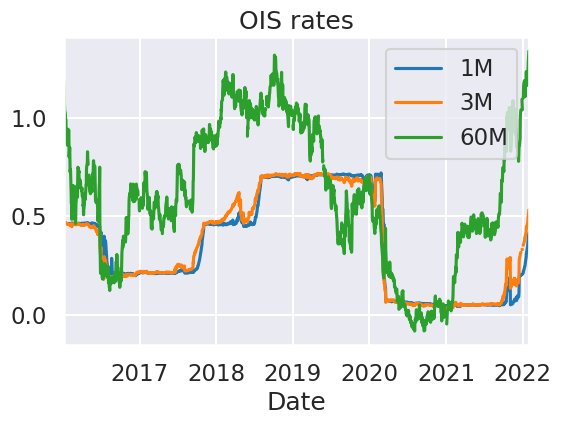

In [18]:
rates[['1M', '3M', '60M']].plot()
plt.title('OIS rates')
plt.xlabel('Date');

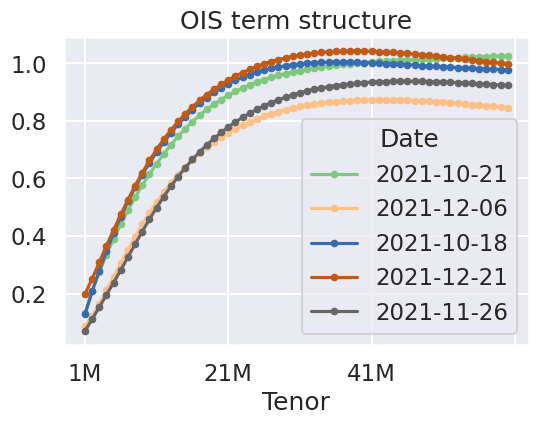

In [19]:
term_structure_df = rates.tail(100).sample(5).T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.', cmap='Accent')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')

# Model PCA



<Axes: >

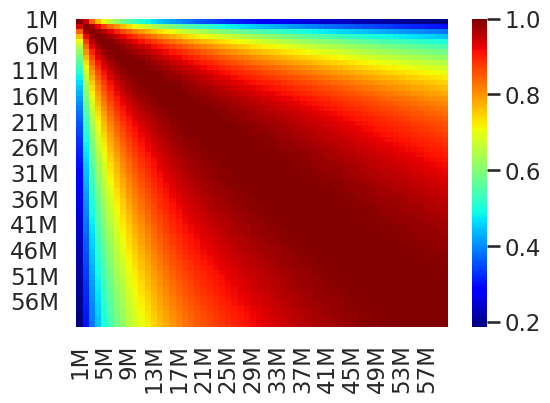

In [20]:
diffs = rates.diff().dropna()
sns.heatmap(diffs.corr(), cmap='jet')

## PCA

### Idea


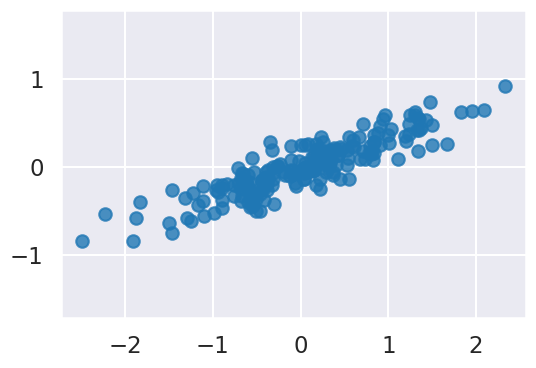

In [22]:
def draw_vector(v0, v1, col, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color=col)
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots()

# plot data
plt.scatter(X[:, 0], X[:, 1], alpha=0.8)
ax.axis('equal');

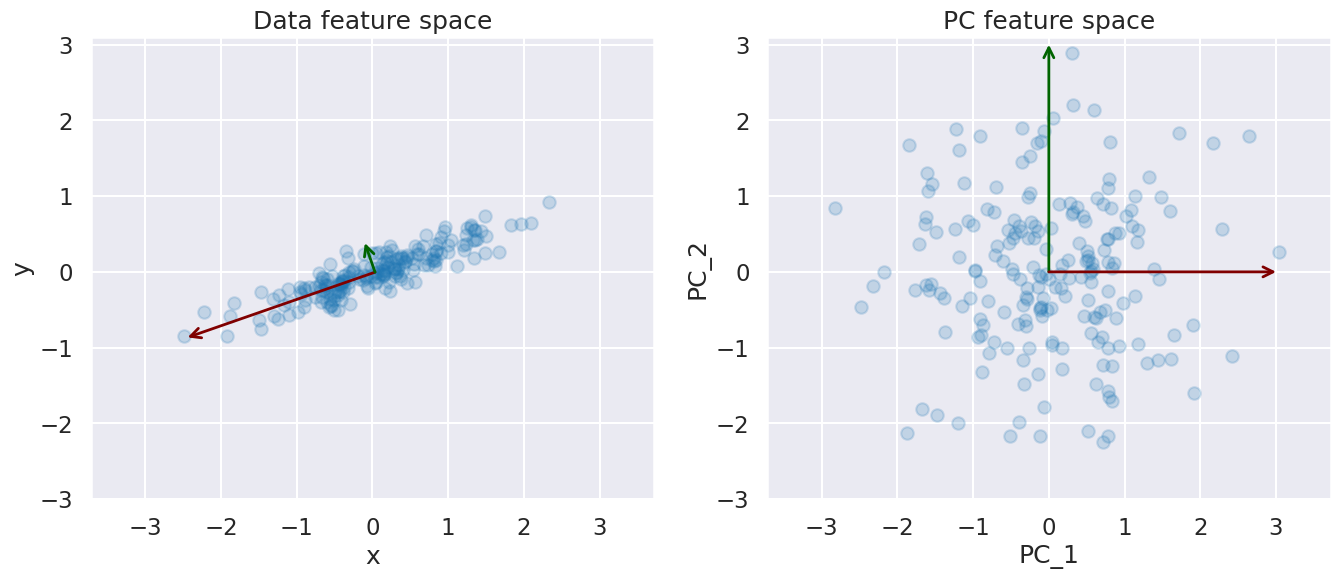

In [23]:
from seaborn.palettes import color_palette
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# plot data
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector, col in zip(pca.explained_variance_, pca.components_, ['maroon', 'darkgreen']):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0], col=col)
ax[0].axis('equal')
ax[0].set(xlabel='x', ylabel='y',
          title='Data feature space',
          xlim=(-5, 5), ylim=(-3, 3.1))

# plot principal components
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1], col='darkgreen')
draw_vector([0, 0], [3, 0], ax=ax[1], col='maroon')
ax[1].axis('equal')
ax[1].set(xlabel='PC_1', ylabel='PC_2',
          title='PC feature space',
          xlim=(-5, 5), ylim=(-3, 3.1));

### Zastosowanie do krzywej OIS

In [26]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
diffs = rates.diff().dropna()
sc.fit(diffs)

diffs_sc = sc.transform(diffs)
pca = PCA()
pca.fit(diffs_sc)

PCA()

<Axes: >

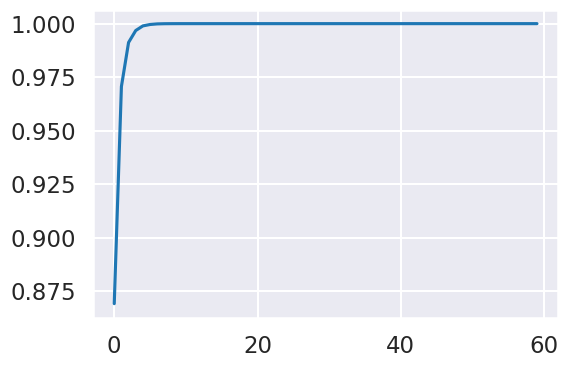

In [42]:
pd.Series(pca.explained_variance_ratio_.cumsum()).plot()

<Axes: >

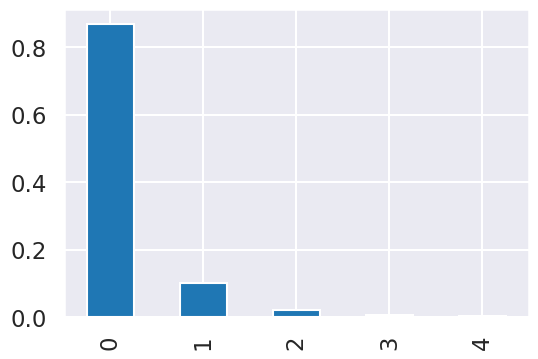

In [44]:
pd.Series(pca.explained_variance_ratio_).head(5).plot(kind = 'bar')

In [54]:
pca3 = PCA(n_components = 3)
pca3.fit(diffs_sc)

PCA(n_components=3)

In [56]:
data_pca = pd.DataFrame(pca3.transform(diffs_sc),
                        index = diffs.index, columns = ['PC1', 'PC2', 'PC3'])
data_pca

,PC1,PC2,PC3
Date,,,
2016-01-05,8.016335,-1.211829,-1.363289
2016-01-06,11.778546,-3.055495,0.214427
2016-01-07,6.923741,-2.068385,-0.400162
2016-01-08,6.349083,-1.167369,-0.318211
2016-01-11,3.459020,-1.209284,-0.462078
...,...,...,...
2022-01-25,-8.907602,-0.743440,0.463989
2022-01-26,-6.183613,-0.024574,0.002335
2022-01-27,-11.883626,-4.808220,2.033516


array([<Axes: xlabel='Date'>, <Axes: xlabel='Date'>,
       <Axes: xlabel='Date'>], dtype=object)

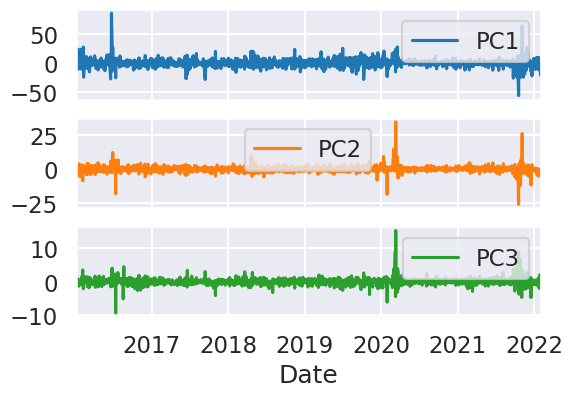

In [57]:
data_pca.plot(subplots=True)

# Monte Carlo



In [ ]:
def simulate(self, dates, x0):
        
  data_pca = pd.DataFrame(self.data['diffs_pca'])
  bootstrap_sample = data_pca.sample(len(dates), replace=True)
  bootstrap_sample.index = dates

  diff_scaled_sim = pd.DataFrame(self.pca.inverse_transform(bootstrap_sample))
  diff_sim = pd.DataFrame(self.scaler.inverse_transform(diff_scaled_sim))

  diff_sim.columns = self.modelled_tenors
  diff_sim.index = dates

  ois_sim = pd.concat([x0, diff_sim], axis=0).cumsum(axis=0)
  return ois_sim

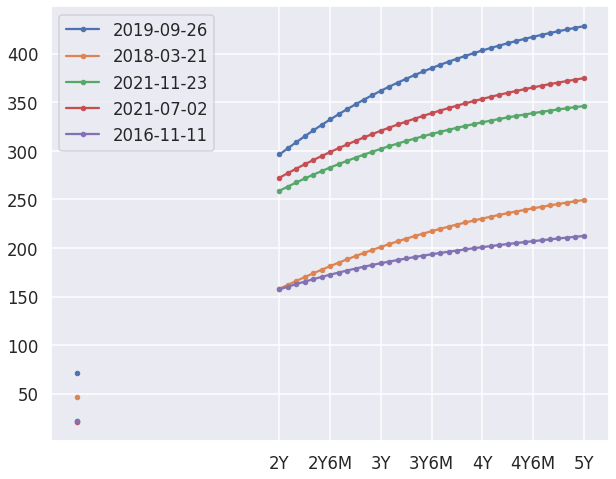

In [ ]:
%matplotlib inline
sns.set_context('talk')

# Simulate long OIS tenors
cutoff_tenor = '2Y'
long_term_model = PCA_term_structure(pca_num = 3, cutoff_tenor = cutoff_tenor)
long_term_model.fit(data=rates)

long_term_sim = long_term_model.simulate(dates=rates.diff().dropna().index,
                                         x0=rates.loc[:, cutoff_tenor:].iloc[[0], :],
                                         sonia_scenario = sonia_sim)

temp_sim = pd.concat([sonia_sim, long_term_sim], axis=1)
plot_df = pd.concat([rates.iloc[[0], :], temp_sim], axis = 0).iloc[1:, :].sample(5)
plot_df.index = plot_df.index.strftime('%Y-%m-%d')
plot_df.T.plot(marker='.')

tenors = long_term_model.modelled_tenors[::6]
plt.xticks([rev_tenor_parser(t) for t in tenors], tenors);

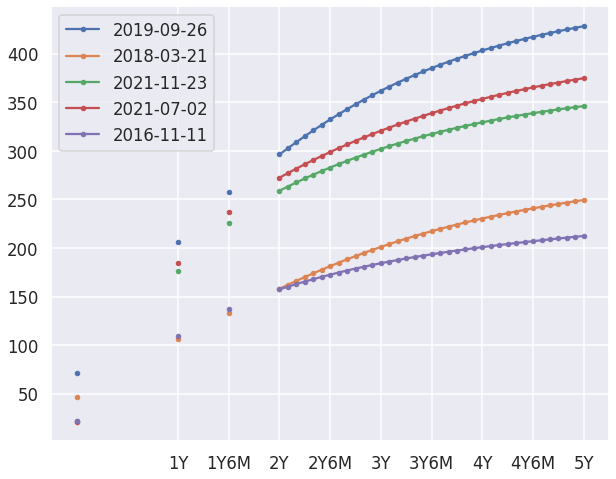

In [ ]:
pivots = ['1Y', '1Y6M']
short_term_model = RegressionShortTermModel(pivot_tenors=pivots,
                                            cutoff=cutoff_tenor)
short_term_model.fit(rates)

plot_df_2 = plot_df.copy()
for tenor in pivots[::-1]:
  plot_df_2[tenor] = short_term_model.predict(X = plot_df_2, tenors=[tenor])

plot_df_2.T.plot(marker='.')
tenors = short_term_model.pivot_tenors + list(long_term_model.modelled_tenors[::6])
plt.xticks([rev_tenor_parser(t) for t in tenors], tenors)
plt.legend();

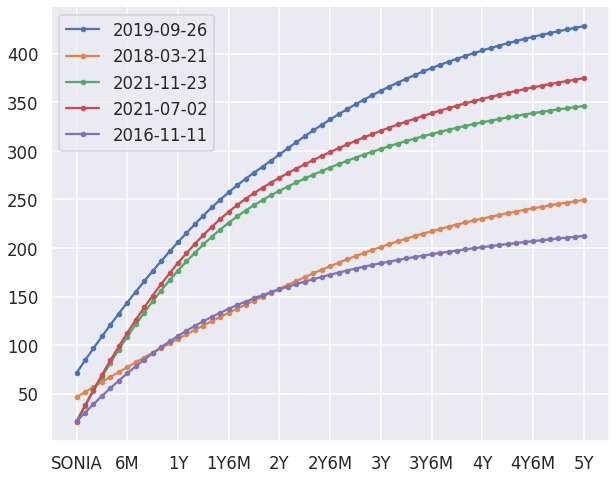

In [ ]:
# Interpolate other tenors
simulation = short_term_model.spline(plot_df_2.dropna(axis=1), kind='quadratic')

simulation.T.plot(marker='.')
tenors = rates.columns[::6]
plt.xticks([rev_tenor_parser(t) for t in tenors], tenors);

In [ ]:
%matplotlib inline
sns.set_context('talk')
plt.rcParams['figure.figsize'] = (10, 8)

# Simulate SONIA
sonia_sim = sonia_model.simulate(dates=rates.diff().dropna().index,
                                 x0=sonia.iloc[[0], :])

# Simulate long OIS tenors
cutoff_tenor = '2Y'
long_term_model = PCA_term_structure(pca_num = 3, cutoff_tenor = cutoff_tenor)
long_term_model.fit(data=rates)

long_term_sim = long_term_model.simulate(dates=rates.diff().dropna().index,
                                         x0=rates.loc[:, cutoff_tenor:].iloc[[0], :],
                                         sonia_scenario = sonia_sim)

temp_sim = pd.concat([sonia_sim, long_term_sim], axis=1)

# Simulate pivots
pivots = ['1M', '3M', '6M', '9M', '1Y6M']
short_term_model = RegressionShortTermModel(pivot_tenors=pivots,
                                            cutoff=cutoff_tenor)
short_term_model.fit(rates)

for pivot in pivots[::-1]:
  temp_sim[pivot] = short_term_model.predict(X = temp_sim, tenors=[pivot])

# Interpolate other tenors
simulation = short_term_model.spline(temp_sim, kind='cubic')

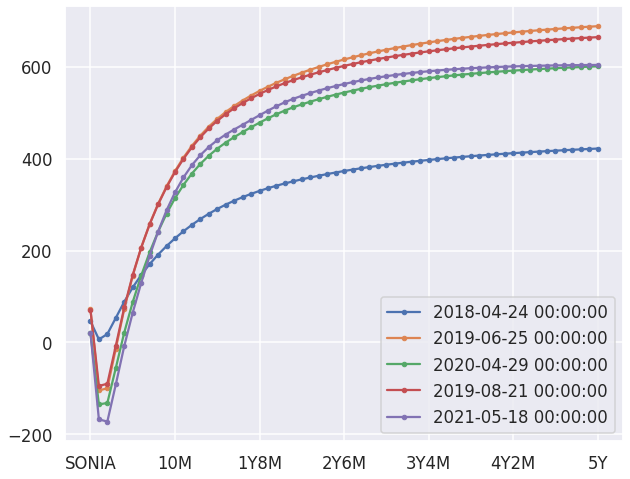

In [ ]:
simulation.sample(5).T.plot(marker='.')

In [ ]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([])     
ax.set_xlim(-2.95, 61.95)
ax.set_ylim(simulation.min().min()*0.9, simulation.max().max()*1.1)
tenors = np.array([3, 6, 9, 12, 24, 36, 48, 60])
plt.xticks(tenors, simulation.columns[tenors]);

def animate(frame_num):
    y = simulation.iloc[[frame_num], :].T
    x = list(range(len(y)))
    line.set_data((x, y))
    line.set_marker('.')
    plt.title(y.columns[0].strftime("%Y-%b-%d"))
    return line

anim = FuncAnimation(fig, animate, frames=len(simulation.index),
                     interval=40, blit=True, repeat=False)

from IPython.display import HTML
HTML(anim.to_html5_video())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1467, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'
